# Uma análise da educação no Brasil
### Endrew Rossin

Durante conversas com amigos professores e profissionais da educação no meu período de trabalho acadêmico, sempre surgia o assunto de como a educação no Brasil está indo de mal a pior, principalmente se pensando na educação básica. Alguns comentavam inclusive que a graduação e níveis superiores já estavam no mesmo caminho. Sabendo que há muitos dados públicos na área de educação no Brasil, decidi fazer uma análise do desempenho de alunos na Prova Brasil, Ela é realizada a cada dois anos e participam todos os estudantes de escolas urbanas do 5°, do 9º e 3º ano do ensino médio de turmas com mais de 20 alunos. Estes desempenhos foram comparados com ferramentas de aprendizado disponibilizadas por suas escolas.  

Para este notebook eu utilizo dados das notas de alunos disponibilizados pelo INEP, utilizo dados do censo escolar também disponibilizados pelo INEP, e utilizo dados geográficos disponibilizados pelo IBGE.

# Criando a base de dados

### Leitura dos dados

Eu começo o projeto importando as bibliotecas que usarei para manipular os dados. Fiz uso do Numpy e do Pandas pois são excelentes bibliotecas para manipulação de grandes quantidades de dados com o Python. Também utilizo o Matplotlib e o Seaborn para visualizar os dados. Uso o geopandas para gerar as visualizações geoespaciais.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
%matplotlib inline
pd.set_option('display.max_columns', None)

Para começar, fiz a leitura dos arquivos com as informações da prova, disponíveis no site do INEP.

In [2]:
dfalunos5EF = pd.read_csv('TS_ALUNO_5EF.csv', sep=',', low_memory = False)

In [3]:
dfalunos9EF = pd.read_csv('TS_ALUNO_9EF.csv', sep=',', low_memory = False)

In [4]:
dfalunos3EM = pd.read_csv('TS_ALUNO_3EM_AG.csv', sep=',', low_memory = False)

In [5]:
print('Número total de alunos: ', dfalunos5EF.shape[0] + dfalunos9EF.shape[0] + dfalunos3EM.shape[0])

Número total de alunos:  6931985


Agora, preciso selecionar apenas as colunas dos dataframes "dfalunos" que serão utilizadas para a montagem da base de dados que será analisada. Selecionei a coluna "tx_resp_q001" que segundo o dicionário disponibilizado pelo INEP para este conjunto de dados informa o sexo do aluno com "A" para masculino e "B" para feminino, dentre outras colunas necessárias para a análise como as notas e os id's da escola e da localização geográfica.

In [6]:
dfalunos5EF = pd.DataFrame(dfalunos5EF, columns=['ID_DEPENDENCIA_ADM','ID_UF','ID_SERIE','ID_ALUNO','ID_ESCOLA','ID_TURMA','PROFICIENCIA_LP_SAEB','PROFICIENCIA_MT_SAEB','TX_RESP_Q001'])
dfalunos9EF = pd.DataFrame(dfalunos9EF, columns=['ID_DEPENDENCIA_ADM','ID_UF','ID_SERIE','ID_ALUNO','ID_ESCOLA','ID_TURMA','PROFICIENCIA_LP_SAEB','PROFICIENCIA_MT_SAEB','TX_RESP_Q001'])
dfalunos3EM = pd.DataFrame(dfalunos3EM, columns=['ID_DEPENDENCIA_ADM','ID_UF','ID_SERIE','ID_ALUNO','ID_ESCOLA','ID_TURMA','PROFICIENCIA_LP_SAEB','PROFICIENCIA_MT_SAEB','TX_RESP_Q001'])

In [7]:
alunos = pd.DataFrame()
alunos = pd.concat([dfalunos5EF,dfalunos9EF,dfalunos3EM])

Temos agora a dependência administrativa da escola, a unidade da federação do aluno, a série do aluno, o ID do aluno, da escola e da turma dele, as proficiências de português, matemática e o sexo.

In [8]:
alunos.head()

,ID_DEPENDENCIA_ADM,ID_UF,ID_SERIE,ID_ALUNO,ID_ESCOLA,ID_TURMA,PROFICIENCIA_LP_SAEB,PROFICIENCIA_MT_SAEB,TX_RESP_Q001
0,3,11,5,21524786,11024666,757200,231.260023,263.311860,B
1,3,11,5,21524787,11024666,757200,142.906301,252.234895,B
2,3,11,5,21524788,11024666,757200,NaN,NaN,NaN
3,3,11,5,21524789,11024666,757200,145.897485,152.702955,A
4,3,11,5,21524790,11024666,757200,238.151321,262.808438,B


### Limpeza dos dados

Começo visualizando como estão os dados faltantes para poder traçar uma estratégia de como lidar com eles. Usando o Seaborn, eu gero um mapa de calor para ter uma informação visual onde são mostrados em branco os valores do conjunto de dados que são nulos.

In [9]:
alunos.isnull().sum()

ID_DEPENDENCIA_ADM            0
ID_UF                         0
ID_SERIE                      0
ID_ALUNO                      0
ID_ESCOLA                     0
ID_TURMA                      0
PROFICIENCIA_LP_SAEB    1543720
PROFICIENCIA_MT_SAEB    1543720
TX_RESP_Q001            1787348
dtype: int64

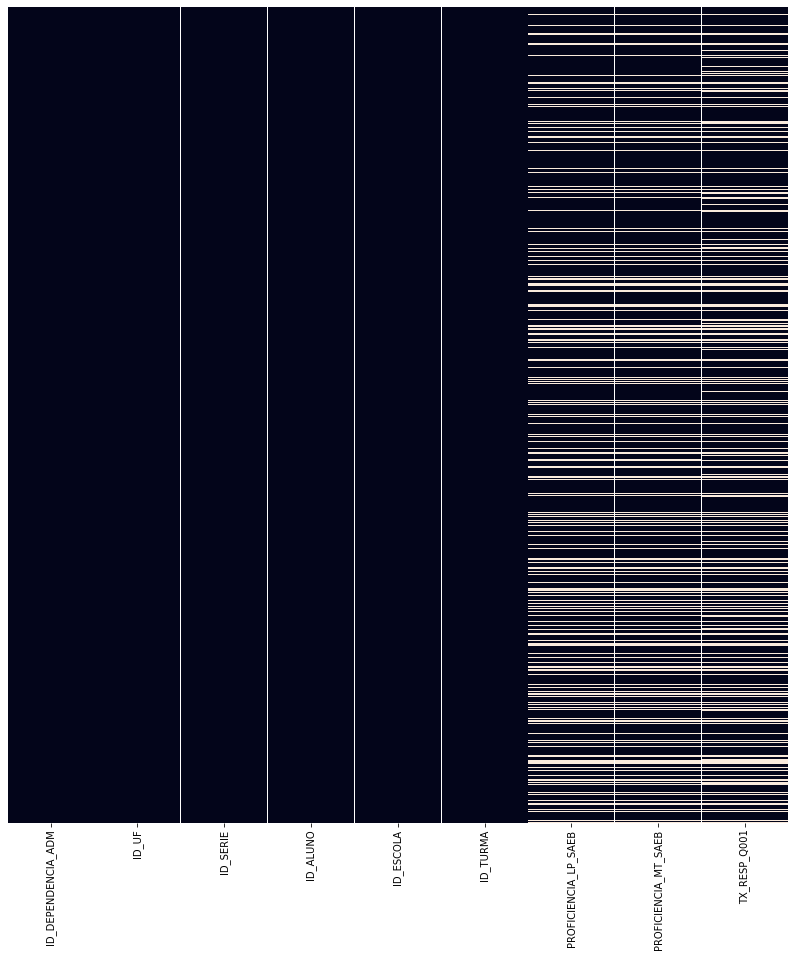

In [10]:
plt.figure(figsize = (14,15))
sns.heatmap(alunos.isnull(), yticklabels=False, cbar=False)
plt.show()

Olhando a imagem podemos ver que a proficiência não foi atribuída a alguns destes alunos. Estes terão de ser descartados. Então eu atribui um novo estado para o objeto dataframe onde apenas as linhas de alunos que tem a proficiência de língua portuguesa não nula e tem a proficiência de matemática não nula constam. Ainda temos a coluna onde vamos identificar o sexo do aluno, que parece não ter sido preenchida por alguns deles, assim como no caso da proficiência estas linhas serão descartadas.

In [11]:
alunos = alunos[(alunos.PROFICIENCIA_LP_SAEB.notnull()) & (alunos.PROFICIENCIA_MT_SAEB.notnull())]

In [12]:
alunos = alunos[alunos.TX_RESP_Q001.notnull()]

In [13]:
print ('O número de dados faltantes é: %s' % alunos.isnull().sum().sum())

O número de dados faltantes é: 0


Pronto, agora temos um dataframe sem valores nulos! Vou trocar o título da coluna "tx_resp_q001" para "sexo", e também os valores de "A" para Masculino e "B" para Feminino. Irei manter esta variável categórica pois será mais interessante para a análise futura que será feita. Fiz essa operação utilizando o método replace do Pandas, onde eu informo a coluna que será feita a operação, os valores que serão substituídos e os valores que entrarão no lugar.

In [14]:
alunos.replace({'TX_RESP_Q001': {'A': 'Masculino', 'B': 'Feminino'}}, inplace= True)

In [15]:
alunos['SEXO'] = alunos['TX_RESP_Q001']
alunos.drop(labels= ['TX_RESP_Q001'], axis=1, inplace = True)

Vou trocar os números da coluna Dependência Administrativa pelo nome do valor correspondente segundo o dicionário disponibilizado para estes microdados no site do INEP (1- Federal, 2-Estadual, 3-Municipal, 4-Privada) 

In [16]:
alunos.replace({'ID_DEPENDENCIA_ADM': {1: 'Federal', 2: 'Estadual', 3:'Municipal',4:'Privada'}}, inplace= True)
alunos['DEPENDENCIA_ADM'] = alunos['ID_DEPENDENCIA_ADM']
alunos.drop(labels= ['ID_DEPENDENCIA_ADM'], axis=1, inplace = True)

Vou fazer um boxplot de cada área, para cada série uma vez que os limites das notas é diferente por série, para verificar se há algum possível erro com as notas dos alunos. Vou verificar se há algum outlier que esteja fora do espectro das proficiências possíveis.

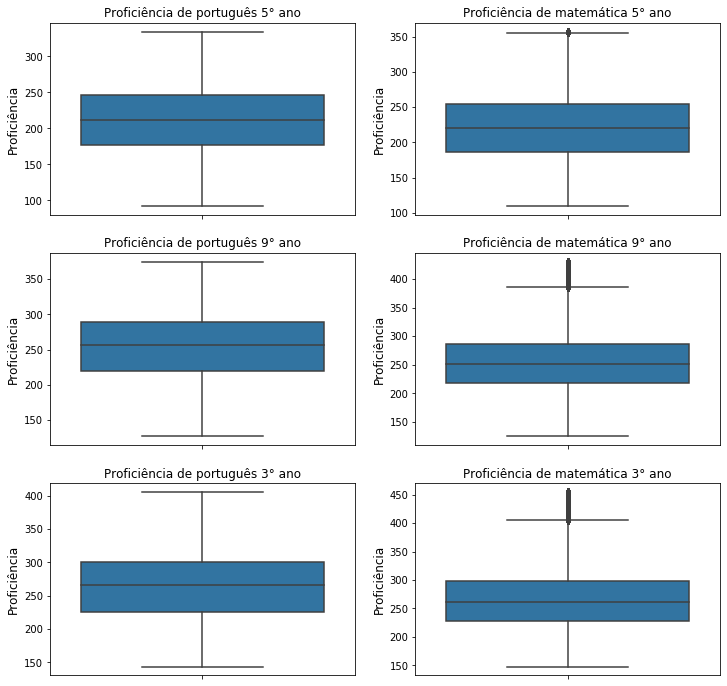

In [17]:
plt.figure(figsize= (12,12))

plt.subplot(3, 2, 1).set_title("Proficiência de português 5° ano")
sns.boxplot(y='PROFICIENCIA_LP_SAEB',data=alunos[alunos.ID_SERIE == 5])
plt.ylabel('Proficiência', fontsize=12)

plt.subplot(3, 2, 2).set_title("Proficiência de matemática 5° ano")
sns.boxplot(y='PROFICIENCIA_MT_SAEB',data=alunos[alunos.ID_SERIE == 5])
plt.ylabel('Proficiência', fontsize=12)

plt.subplot(3, 2, 3).set_title("Proficiência de português 9° ano")
sns.boxplot(y='PROFICIENCIA_LP_SAEB',data=alunos[alunos.ID_SERIE == 9])
plt.ylabel('Proficiência', fontsize=12)

plt.subplot(3, 2, 4).set_title("Proficiência de matemática 9° ano")
sns.boxplot(y='PROFICIENCIA_MT_SAEB',data=alunos[alunos.ID_SERIE == 9])
plt.ylabel('Proficiência', fontsize=12)

plt.subplot(3, 2, 5).set_title("Proficiência de português 3° ano")
sns.boxplot(y='PROFICIENCIA_LP_SAEB',data=alunos[(alunos.ID_SERIE == 12) | (alunos.ID_SERIE == 13)])
plt.ylabel('Proficiência', fontsize=12)

plt.subplot(3, 2, 6).set_title("Proficiência de matemática 3° ano")
sns.boxplot(y='PROFICIENCIA_MT_SAEB',data=alunos[(alunos.ID_SERIE == 12) | (alunos.ID_SERIE == 13)])
plt.ylabel('Proficiência', fontsize=12)

plt.show()

Olhando para os plots, vemos que as notas de português não apresentam nenhuma anomalia, e as de matemática apenas tem alguns outliers na parte superior que estão dentro das notas possíveis na prova. Isso indica que o nosso conjunto de dados provavelmente não tem valores errados. Podemos então continuar para a próxima fase do projeto.

### Adicionando as informações do censo das escolas

Agora é preciso também adicionar as informações sobre as escolas dos alunos. Peguei as informações de microdados de um censo escolar disponibilizado pelo site do INEP. Este censo, dentro de muitos outros dados, tem os que estou interessado que são sobre os laboratórios de informática, os computadores disponíveis para os alunos, os laboratórios de ciências e bibliotecas. Adicionarei as informações criando um novo dataframe com os dados do censo contendo apenas as colunas que utilizarei. Também alterei o nome da coluna com o código da entidade para ficar com o mesmo nome desta informação no dataframe das informações dos alunos e posteriormente ser feito o merge. 

In [18]:
dfcenso = pd.read_csv('ESCOLAS.csv', sep='|', low_memory = False, encoding='cp1252')
dfcenso.shape

(282362, 166)

In [19]:
dfcenso.head()

,NU_ANO_CENSO,CO_ENTIDADE,NO_ENTIDADE,CO_ORGAO_REGIONAL,TP_SITUACAO_FUNCIONAMENTO,DT_ANO_LETIVO_INICIO,DT_ANO_LETIVO_TERMINO,CO_REGIAO,CO_MESORREGIAO,CO_MICRORREGIAO,CO_UF,CO_MUNICIPIO,CO_DISTRITO,TP_DEPENDENCIA,TP_LOCALIZACAO,TP_CATEGORIA_ESCOLA_PRIVADA,IN_CONVENIADA_PP,TP_CONVENIO_PODER_PUBLICO,IN_MANT_ESCOLA_PRIVADA_EMP,IN_MANT_ESCOLA_PRIVADA_ONG,IN_MANT_ESCOLA_PRIVADA_SIND,IN_MANT_ESCOLA_PRIVADA_SIST_S,IN_MANT_ESCOLA_PRIVADA_S_FINS,CO_ESCOLA_SEDE_VINCULADA,CO_IES_OFERTANTE,TP_REGULAMENTACAO,IN_LOCAL_FUNC_PREDIO_ESCOLAR,TP_OCUPACAO_PREDIO_ESCOLAR,IN_LOCAL_FUNC_SALAS_EMPRESA,IN_LOCAL_FUNC_SOCIOEDUCATIVO,IN_LOCAL_FUNC_UNID_PRISIONAL,IN_LOCAL_FUNC_PRISIONAL_SOCIO,IN_LOCAL_FUNC_TEMPLO_IGREJA,IN_LOCAL_FUNC_CASA_PROFESSOR,IN_LOCAL_FUNC_GALPAO,TP_OCUPACAO_GALPAO,IN_LOCAL_FUNC_SALAS_OUTRA_ESC,IN_LOCAL_FUNC_OUTROS,IN_PREDIO_COMPARTILHADO,IN_AGUA_FILTRADA,IN_AGUA_REDE_PUBLICA,IN_AGUA_POCO_ARTESIANO,IN_AGUA_CACIMBA,IN_AGUA_FONTE_RIO,IN_AGUA_INEXISTENTE,IN_ENERGIA_REDE_PUBLICA,IN_ENERGIA_GERADOR,IN_ENERGIA_OUTROS,IN_ENERGIA_INEXISTENTE,IN_ESGOTO_REDE_PUBLICA,IN_ESGOTO_FOSSA,IN_ESGOTO_INEXISTENTE,IN_LIXO_COLETA_PERIODICA,IN_LIXO_QUEIMA,IN_LIXO_JOGA_OUTRA_AREA,IN_LIXO_RECICLA,IN_LIXO_ENTERRA,IN_LIXO_OUTROS,IN_SALA_DIRETORIA,IN_SALA_PROFESSOR,IN_LABORATORIO_INFORMATICA,IN_LABORATORIO_CIENCIAS,IN_SALA_ATENDIMENTO_ESPECIAL,IN_QUADRA_ESPORTES_COBERTA,IN_QUADRA_ESPORTES_DESCOBERTA,IN_QUADRA_ESPORTES,IN_COZINHA,IN_BIBLIOTECA,IN_SALA_LEITURA,IN_BIBLIOTECA_SALA_LEITURA,IN_PARQUE_INFANTIL,IN_BERCARIO,IN_BANHEIRO_FORA_PREDIO,IN_BANHEIRO_DENTRO_PREDIO,IN_BANHEIRO_EI,IN_BANHEIRO_PNE,IN_DEPENDENCIAS_PNE,IN_SECRETARIA,IN_BANHEIRO_CHUVEIRO,IN_REFEITORIO,IN_DESPENSA,IN_ALMOXARIFADO,IN_AUDITORIO,IN_PATIO_COBERTO,IN_PATIO_DESCOBERTO,IN_ALOJAM_ALUNO,IN_ALOJAM_PROFESSOR,IN_AREA_VERDE,IN_LAVANDERIA,IN_DEPENDENCIAS_OUTRAS,NU_SALAS_EXISTENTES,NU_SALAS_UTILIZADAS,IN_EQUIP_TV,IN_EQUIP_VIDEOCASSETE,IN_EQUIP_DVD,IN_EQUIP_PARABOLICA,IN_EQUIP_COPIADORA,IN_EQUIP_RETROPROJETOR,IN_EQUIP_IMPRESSORA,IN_EQUIP_IMPRESSORA_MULT,IN_EQUIP_SOM,IN_EQUIP_MULTIMIDIA,IN_EQUIP_FAX,IN_EQUIP_FOTO,IN_COMPUTADOR,NU_EQUIP_TV,NU_EQUIP_VIDEOCASSETE,NU_EQUIP_DVD,NU_EQUIP_PARABOLICA,NU_EQUIP_COPIADORA,NU_EQUIP_RETROPROJETOR,NU_EQUIP_IMPRESSORA,NU_EQUIP_IMPRESSORA_MULT,NU_EQUIP_SOM,NU_EQUIP_MULTIMIDIA,NU_EQUIP_FAX,NU_EQUIP_FOTO,NU_COMPUTADOR,NU_COMP_ADMINISTRATIVO,NU_COMP_ALUNO,IN_INTERNET,IN_BANDA_LARGA,NU_FUNCIONARIOS,IN_ALIMENTACAO,TP_AEE,TP_ATIVIDADE_COMPLEMENTAR,IN_FUNDAMENTAL_CICLOS,TP_LOCALIZACAO_DIFERENCIADA,IN_MATERIAL_ESP_QUILOMBOLA,IN_MATERIAL_ESP_INDIGENA,IN_MATERIAL_ESP_NAO_UTILIZA,IN_EDUCACAO_INDIGENA,TP_INDIGENA_LINGUA,CO_LINGUA_INDIGENA,IN_BRASIL_ALFABETIZADO,IN_FINAL_SEMANA,IN_FORMACAO_ALTERNANCIA,IN_MEDIACAO_PRESENCIAL,IN_MEDIACAO_SEMIPRESENCIAL,IN_MEDIACAO_EAD,IN_ESPECIAL_EXCLUSIVA,IN_REGULAR,IN_EJA,IN_PROFISSIONALIZANTE,IN_COMUM_CRECHE,IN_COMUM_PRE,IN_COMUM_FUND_AI,IN_COMUM_FUND_AF,IN_COMUM_MEDIO_MEDIO,IN_COMUM_MEDIO_INTEGRADO,IN_COMUM_MEDIO_NORMAL,IN_ESP_EXCLUSIVA_CRECHE,IN_ESP_EXCLUSIVA_PRE,IN_ESP_EXCLUSIVA_FUND_AI,IN_ESP_EXCLUSIVA_FUND_AF,IN_ESP_EXCLUSIVA_MEDIO_MEDIO,IN_ESP_EXCLUSIVA_MEDIO_INTEGR,IN_ESP_EXCLUSIVA_MEDIO_NORMAL,IN_COMUM_EJA_FUND,IN_COMUM_EJA_MEDIO,IN_COMUM_EJA_PROF,IN_ESP_EXCLUSIVA_EJA_FUND,IN_ESP_EXCLUSIVA_EJA_MEDIO,IN_ESP_EXCLUSIVA_EJA_PROF,IN_COMUM_PROF,IN_ESP_EXCLUSIVA_PROF
0,2017,50032062,CENTRO DE EDUCACAO INFANTIL GERALDO ANTONIO LOPES,NaN,1,06/02/2017,11/12/2017,5,5004,50010,50,5001243,500124305,3,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,10.0,10.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,11.0,0.0,9.0,0.0,1.0,1.0,3.0,0.0,10.0,0.0,0.0,0.0,4.0,4.0,0.0,1.0,1.0,62.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

In [20]:
censo = pd.DataFrame(dfcenso, columns=['CO_ENTIDADE','CO_MUNICIPIO','CO_MICRORREGIAO','CO_UF','IN_LABORATORIO_INFORMATICA','NU_COMP_ALUNO','IN_LABORATORIO_CIENCIAS','IN_BIBLIOTECA'])
censo['ID_ESCOLA'] = censo['CO_ENTIDADE']
censo.drop(labels='CO_ENTIDADE', axis=1, inplace = True)

In [21]:
censo.head()

,CO_MUNICIPIO,CO_MICRORREGIAO,CO_UF,IN_LABORATORIO_INFORMATICA,NU_COMP_ALUNO,IN_LABORATORIO_CIENCIAS,IN_BIBLIOTECA,ID_ESCOLA
0,5001243,50010,50,0.0,0.0,0.0,0.0,50032062
1,1100122,11004,11,1.0,29.0,1.0,1.0,11016094
2,2100477,21008,21,0.0,0.0,0.0,0.0,21079196
3,5103007,51017,51,1.0,1.0,0.0,1.0,51062879
4,3158201,31036,31,0.0,0.0,0.0,0.0,31051659


Combinei os dataframes na coluna ID_ESCOLA de modo "left", mantendo todos os dados dos alunos e preenchendo com NaN os dados do censo que não puderam ser preenchidos (entidades com código mascarado).

In [22]:
dffinal = pd.merge(alunos, censo, how='left', on='ID_ESCOLA')

In [23]:
dffinal.head()

,ID_UF,ID_SERIE,ID_ALUNO,ID_ESCOLA,ID_TURMA,PROFICIENCIA_LP_SAEB,PROFICIENCIA_MT_SAEB,SEXO,DEPENDENCIA_ADM,CO_MUNICIPIO,CO_MICRORREGIAO,CO_UF,IN_LABORATORIO_INFORMATICA,NU_COMP_ALUNO,IN_LABORATORIO_CIENCIAS,IN_BIBLIOTECA
0,11,5,21524786,11024666,757200,231.260023,263.311860,Feminino,Municipal,1100015.0,11006.0,11.0,0.0,0.0,0.0,0.0
1,11,5,21524787,11024666,757200,142.906301,252.234895,Feminino,Municipal,1100015.0,11006.0,11.0,0.0,0.0,0.0,0.0
2,11,5,21524789,11024666,757200,145.897485,152.702955,Masculino,Municipal,1100015.0,11006.0,11.0,0.0,0.0,0.0,0.0
3,11,5,21524790,11024666,757200,238.151321,262.808438,Feminino,Municipal,1100015.0,11006.0,11.0,0.0,0.0,0.0,0.0
4,11,5,21524792,11024666,757200,235.423869,269.327887,Feminino,Municipal,1100015.0,11006.0,11.0,0.0,0.0,0.0,0.0


# Análise de dados

### Análise descritiva

In [24]:
print ('Existem %s alunos no nosso dataframe final, de %s turmas diferentes em %s escolas.' 
       % (dffinal.ID_ALUNO.nunique(),dffinal.ID_TURMA.nunique(),dffinal.ID_ESCOLA.nunique()))

Existem 5142986 alunos no nosso dataframe final, de 237278 turmas diferentes em 82242 escolas.


Temos informações de um pouco mais de mulheres do que homens.

In [25]:
Frequencia_Sexos = dffinal.SEXO.value_counts()
Percentual_Sexos = (dffinal.SEXO.value_counts(normalize = True).round(2)*100).astype(int)
dist_Sexos = pd.DataFrame({'Frequência':Frequencia_Sexos,'Porcentagem':Percentual_Sexos})
dist_Sexos

,Frequência,Porcentagem
Feminino,2636237,51
Masculino,2506749,49


A grande maioria dos alunos estudam em escolas Estaduais e Municipais.

In [26]:
Frequencia_DepAdm = dffinal.DEPENDENCIA_ADM.value_counts()
Percentual_DepAdm = dffinal.DEPENDENCIA_ADM.value_counts(normalize = True).round(3)*100
dist_DepAdm = pd.DataFrame({'Frequência':Frequencia_DepAdm,'Porcentagem':Percentual_DepAdm})
dist_DepAdm

,Frequência,Porcentagem
Estadual,2611488,50.8
Municipal,2423816,47.1
Privada,99646,1.9
Federal,8036,0.2


Nos gráficos de distribuição a seguir, podemos ver que as curvas tem uma ligeira assimetria positiva para todos os anos. 

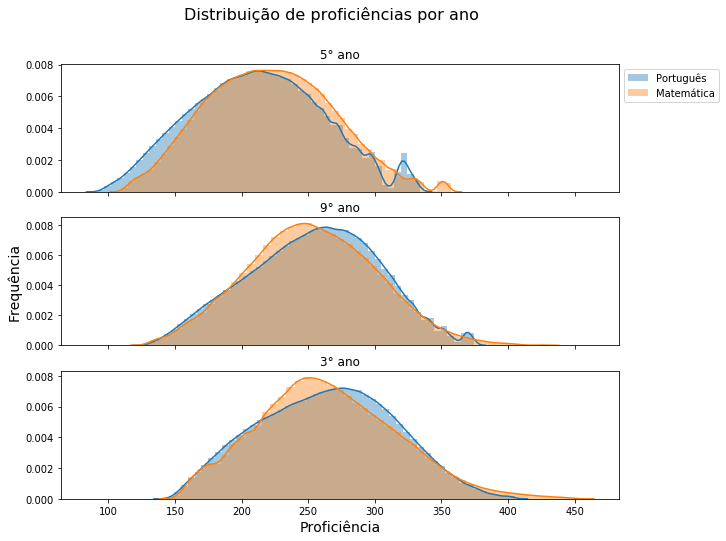

In [27]:
fig, axes = plt.subplots(figsize=(10, 8), nrows=3, ncols=1, sharex=True)
fig.suptitle('Distribuição de proficiências por ano', fontsize=16)
                
axes[0].set_title("5° ano")
sns.distplot(dffinal[dffinal.ID_SERIE == 5]['PROFICIENCIA_LP_SAEB'].values, bins=50, ax=axes[0], label='Português')
sns.distplot(dffinal[dffinal.ID_SERIE == 5]['PROFICIENCIA_MT_SAEB'].values, bins=50, ax=axes[0], label='Matemática')

axes[1].set_title("9° ano")
sns.distplot(dffinal[dffinal.ID_SERIE == 9]['PROFICIENCIA_LP_SAEB'].values, bins=50, ax=axes[1])
sns.distplot(dffinal[dffinal.ID_SERIE == 9]['PROFICIENCIA_MT_SAEB'].values, bins=50, ax=axes[1])

axes[2].set_title("3° ano")
sns.distplot(dffinal[dffinal.ID_SERIE == 12]['PROFICIENCIA_LP_SAEB'].values, bins=50, ax=axes[2])
sns.distplot(dffinal[dffinal.ID_SERIE == 12]['PROFICIENCIA_MT_SAEB'].values, bins=50, ax=axes[2])

axes[0].legend(bbox_to_anchor=(1, 1), loc='upper left', borderaxespad=0.5)
plt.xlabel('Proficiência', fontsize=14)
axes[1].set_ylabel('Frequência', fontsize=14)
plt.subplots_adjust(hspace=0.2)
plt.show()

Uma boa forma de comparação que pode ser feita entre os alunos é entre os 10% que tiram melhores notas e os 10% que tiram piores notas. Para fazer essa comparação, utilizei o comando do Pandas "quantile" que retorna o valor da porcentagem específica que divide os dados de minha escolha (10% e 90%).Tirei a mediana dos valores abaixo de 10% e acima de 90%, por se tratarem de pontos extremos dos dados onde outliers podem fazer com que a média não seja representativa. Calculei a mediana para todas as séries e matérias separadamente. Para poder comparar o tamanho da diferença de proficiência entre os 10% com menores notas e os 10% com maiores notas eu gerei barplots com as notas.

Faço primeiro os calculos para português

In [28]:
Nota10_5LP = (dffinal[(dffinal.ID_SERIE == 5) & (dffinal.PROFICIENCIA_LP_SAEB <= dffinal[dffinal.ID_SERIE == 5].PROFICIENCIA_LP_SAEB.quantile(0.1))].PROFICIENCIA_LP_SAEB.median())
Nota90_5LP = (dffinal[(dffinal.ID_SERIE == 5) & (dffinal.PROFICIENCIA_LP_SAEB >= dffinal[dffinal.ID_SERIE == 5].PROFICIENCIA_LP_SAEB.quantile(0.9))].PROFICIENCIA_LP_SAEB.median())

In [29]:
Nota10_9LP = (dffinal[(dffinal.ID_SERIE == 9) & (dffinal.PROFICIENCIA_LP_SAEB <= dffinal[dffinal.ID_SERIE == 9].PROFICIENCIA_LP_SAEB.quantile(0.1))].PROFICIENCIA_LP_SAEB.median())
Nota90_9LP = (dffinal[(dffinal.ID_SERIE == 9) & (dffinal.PROFICIENCIA_LP_SAEB >= dffinal[dffinal.ID_SERIE == 9].PROFICIENCIA_LP_SAEB.quantile(0.9))].PROFICIENCIA_LP_SAEB.median())

In [30]:
Nota10_12LP = (dffinal[(dffinal.ID_SERIE == 12) & (dffinal.PROFICIENCIA_LP_SAEB <= dffinal[dffinal.ID_SERIE == 12].PROFICIENCIA_LP_SAEB.quantile(0.1))].PROFICIENCIA_LP_SAEB.median())
Nota90_12LP = (dffinal[(dffinal.ID_SERIE == 12) & (dffinal.PROFICIENCIA_LP_SAEB >= dffinal[dffinal.ID_SERIE == 12].PROFICIENCIA_LP_SAEB.quantile(0.9))].PROFICIENCIA_LP_SAEB.median())

Repito o mesmo procedimento, porém para Matemática.

In [31]:
Nota10_5MT = (dffinal[(dffinal.ID_SERIE == 5) & (dffinal.PROFICIENCIA_MT_SAEB <= dffinal[dffinal.ID_SERIE == 5].PROFICIENCIA_MT_SAEB.quantile(0.1))].PROFICIENCIA_MT_SAEB.median())
Nota90_5MT = (dffinal[(dffinal.ID_SERIE == 5) & (dffinal.PROFICIENCIA_MT_SAEB >= dffinal[dffinal.ID_SERIE == 5].PROFICIENCIA_MT_SAEB.quantile(0.9))].PROFICIENCIA_MT_SAEB.median())

In [32]:
Nota10_9MT = (dffinal[(dffinal.ID_SERIE == 9) & (dffinal.PROFICIENCIA_MT_SAEB <= dffinal[dffinal.ID_SERIE == 9].PROFICIENCIA_MT_SAEB.quantile(0.1))].PROFICIENCIA_MT_SAEB.median())
Nota90_9MT = (dffinal[(dffinal.ID_SERIE == 9) & (dffinal.PROFICIENCIA_MT_SAEB >= dffinal[dffinal.ID_SERIE == 9].PROFICIENCIA_MT_SAEB.quantile(0.9))].PROFICIENCIA_MT_SAEB.median())

In [33]:
Nota10_12MT = (dffinal[(dffinal.ID_SERIE == 12) & (dffinal.PROFICIENCIA_MT_SAEB <= dffinal[dffinal.ID_SERIE == 12].PROFICIENCIA_MT_SAEB.quantile(0.1))].PROFICIENCIA_MT_SAEB.median())
Nota90_12MT = (dffinal[(dffinal.ID_SERIE == 12) & (dffinal.PROFICIENCIA_MT_SAEB >= dffinal[dffinal.ID_SERIE == 12].PROFICIENCIA_MT_SAEB.quantile(0.9))].PROFICIENCIA_MT_SAEB.median())

Crio um dataframe com as informações de cada matéria

In [34]:
dif_notasLP_df = pd.DataFrame({'5 - 10%':Nota10_5LP,'5 - 90%':Nota90_5LP,'9 - 10%':Nota10_9LP,'9 - 90%':Nota90_9LP,'<10%':Nota10_12LP,'>90%':Nota90_12LP},index=['Proficiência'])
dif_notasMT_df = pd.DataFrame({'5 - 10%':Nota10_5MT,'5 - 90%':Nota90_5MT,'9 - 10%':Nota10_9MT,'9 - 90%':Nota90_9MT,'<10%':Nota10_12MT,'>90%':Nota90_12MT},index=['Proficiência'])

Crio o barplot para comparação dos alunos por série e matéria

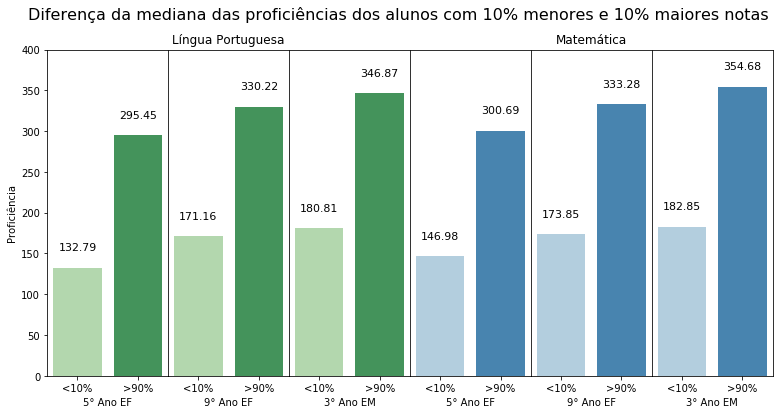

In [35]:
fig, axes = plt.subplots(figsize=(13, 6), ncols=6, sharey=True, sharex=True)
fig.suptitle('Diferença da mediana das proficiências dos alunos com 10% menores e 10% maiores notas', fontsize=16)

sns.set_style({'ytick.left': True})
sns.barplot(data=dif_notasLP_df[['5 - 10%','5 - 90%']], palette='Greens', ax=axes[0])
axes[0].set(title='',ylabel='Proficiência', xlabel='5° Ano EF')
sns.set_style({'ytick.left': False})
sns.barplot(data=dif_notasLP_df[['9 - 10%','9 - 90%']], palette='Greens', ax=axes[1])
axes[1].set(title='Língua Portuguesa',ylabel='', xlabel='9° Ano EF')
sns.set_style({'ytick.left': False})
sns.barplot(data=dif_notasLP_df[['<10%','>90%']], palette='Greens', ax=axes[2])
axes[2].set(title='',ylabel='', xlabel='3° Ano EM')

sns.set_style({'ytick.left': False})
sns.barplot(data=dif_notasMT_df[['5 - 10%','5 - 90%']], palette='Blues', ax=axes[3])
axes[3].set(title='',ylabel='', xlabel='5° Ano EF')
sns.set_style({'ytick.left': False})
sns.barplot(data=dif_notasMT_df[['9 - 10%','9 - 90%']], palette='Blues', ax=axes[4])
axes[4].set(title='Matemática',ylabel='', xlabel='9° Ano EF')
sns.set_style({'ytick.left': False})
sns.barplot(data=dif_notasMT_df[['<10%','>90%']], palette='Blues', ax=axes[5])
axes[5].set(title='',ylabel='', xlabel='3° Ano EM')

plt.ylim(0,400)
plt.ylabel('')
plt.subplots_adjust(wspace=0)

for i in range(6):
    axes[i].tick_params(top=False, bottom=True, left=False, right=False)
    for p in axes[i].patches:
            axes[i].annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=11, color='black', xytext=(0, 20),
                textcoords='offset points')
            
axes[0].tick_params(top=False, bottom=True, left=True, right=False)

Podemos ver que em todas as séries, tanto em português quanto em matemática há uma grande disparidade entre os alunos que tem as notas mais baixas e os que tem as notas mais altas. 

O próximo passo será analisar agora a dependência administrativa das escolas. Criei um boxplot para poder comparar qual dependência administrativa tem alunos com melhores notas.

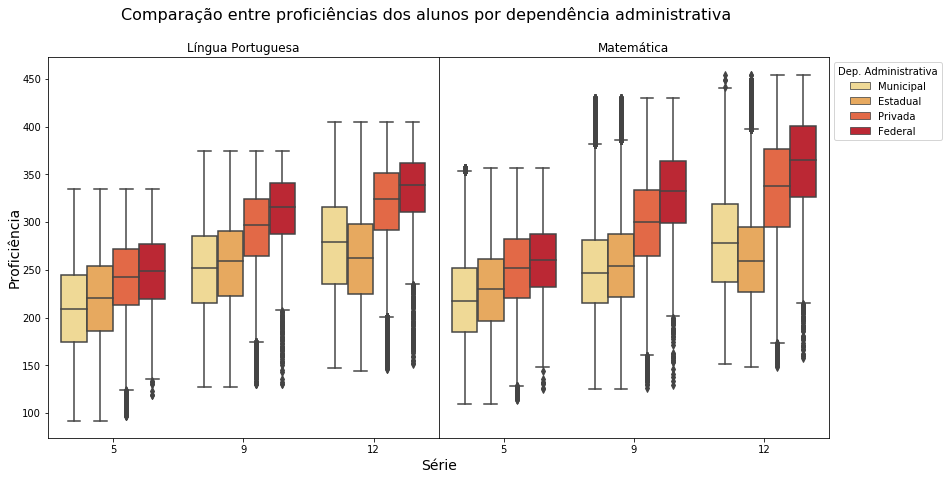

In [36]:
fig, axes = plt.subplots(figsize=(14, 7), ncols=2, sharey=True)
fig.suptitle('Comparação entre proficiências dos alunos por dependência administrativa', fontsize=16)


sns.boxplot(x='ID_SERIE',y='PROFICIENCIA_LP_SAEB',hue='DEPENDENCIA_ADM',data=dffinal,palette='YlOrRd', ax=axes[0])
axes[0].set(title='Língua Portuguesa',ylabel='', xlabel='')

sns.boxplot(x='ID_SERIE',y='PROFICIENCIA_MT_SAEB',hue='DEPENDENCIA_ADM',data=dffinal,palette='YlOrRd', ax=axes[1])
axes[1].set(title='Matemática',ylabel='', xlabel='')

axes[0].tick_params(top=False, bottom=True, left=True, right=False)
plt.legend(title = 'Dep. Administrativa',bbox_to_anchor=(1, 1), loc='upper left', borderaxespad=0.5)
axes[0].get_legend().remove()
plt.subplots_adjust(wspace=0)

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.ylabel("Proficiência" , fontsize=14)
plt.xlabel("Série" , fontsize=14)
plt.show()

Um fato interessante que pode ser observado no plot, é que 25% dos alunos de escolas privadas que tiraram menores notas na 12 série do ensino médio(3° ano), em Matemática, foram melhores que 75% dos alunos de escolas estaduais da mesma série e matéria. Quando comparado com as escolas federais a diferença fica mais evidente. Podemos observar melhor a distribuição das proficiencias neste caso com o Violinplot.

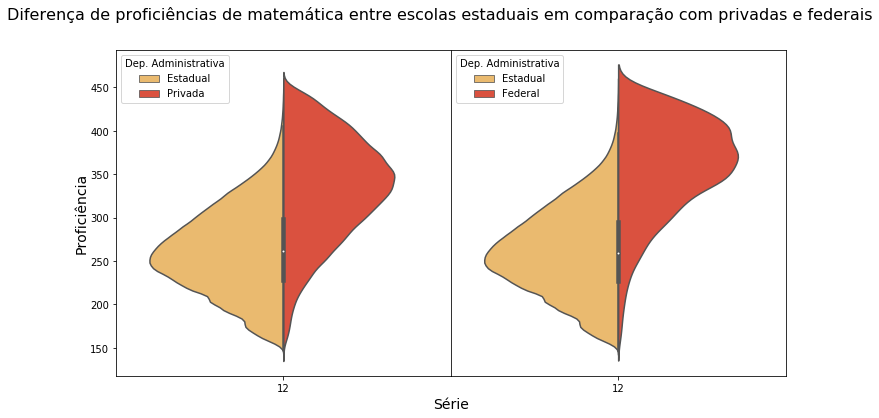

In [37]:
fig, axes = plt.subplots(figsize=(12, 6), ncols=2, sharey=True)
fig.suptitle('Diferença de proficiências de matemática entre escolas estaduais em comparação com privadas e federais', fontsize=16)
sns.violinplot(x=dffinal[dffinal.ID_SERIE == 12].ID_SERIE,y='PROFICIENCIA_MT_SAEB',hue='DEPENDENCIA_ADM', data=dffinal[(dffinal.DEPENDENCIA_ADM == 'Estadual') | (dffinal.DEPENDENCIA_ADM == 'Privada')], palette='YlOrRd',split=True, ax=axes[0])
axes[0].legend(title = 'Dep. Administrativa', loc='upper left')
sns.violinplot(x=dffinal[dffinal.ID_SERIE == 12].ID_SERIE,y='PROFICIENCIA_MT_SAEB',hue='DEPENDENCIA_ADM', data=dffinal[(dffinal.DEPENDENCIA_ADM == 'Estadual') | (dffinal.DEPENDENCIA_ADM == 'Federal')], palette='YlOrRd',split=True, ax=axes[1])
axes[1].legend(title = 'Dep. Administrativa', loc='upper left')
axes[0].set(xlabel='', ylabel='')
axes[1].set(xlabel='', ylabel='')
# axes[0].set_title('Matemática')
# axes[1].set_title('Matemática')
plt.subplots_adjust(wspace=0)
axes[0].tick_params(top=False, bottom=True, left=True, right=False)

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.ylabel("Proficiência" , fontsize=14)
plt.xlabel("Série" , fontsize=14)
plt.show()

Continuando com a nossa análise do ensino médio. Vamos ver como os computadores disponíveis para os alunos influenciam em suas notas.

Criei um novo dataframe apenas com alunos do ensino médio e agrupei os dados por escola, tirando a média de notas por escola.

In [38]:
dffinalEM = dffinal[dffinal.ID_SERIE == 12]

In [39]:
dffinalEM_PorEscola = dffinalEM.groupby(dffinalEM.ID_ESCOLA).mean()
dffinalEM_PorEscola.head()

,ID_UF,ID_SERIE,ID_ALUNO,ID_TURMA,PROFICIENCIA_LP_SAEB,PROFICIENCIA_MT_SAEB,CO_MUNICIPIO,CO_MICRORREGIAO,CO_UF,IN_LABORATORIO_INFORMATICA,NU_COMP_ALUNO,IN_LABORATORIO_CIENCIAS,IN_BIBLIOTECA
ID_ESCOLA,,,,,,,,,,,,,
11000260,11.0,12.0,2.149008e+07,827912.619565,260.750796,266.581174,1100205.0,11001.0,11.0,1.0,20.0,0.0,1.0
11000554,11.0,12.0,2.149144e+07,885728.860000,242.983280,251.267086,1100205.0,11001.0,11.0,0.0,8.0,0.0,0.0
11000597,11.0,12.0,2.149165e+07,868641.000000,266.001193,274.655804,1100205.0,11001.0,11.0,0.0,7.0,1.0,1.0
11000678,11.0,12.0,2.149199e+07,905659.816901,283.378190,281.112675,1100205.0,11001.0,11.0,1.0,30.0,1.0,1.0
11000856,11.0,12.0,2.149256e+07,851435.000000,247.825104,250.998174,1100205.0,11001.0,11.0,1.0,10.0,1.0,1.0


Gerei um gráfico de espalhamento para demonstrar a relação entre as notas dos alunos e o número de computadores disponíveis para os mesmos e suas escolas.

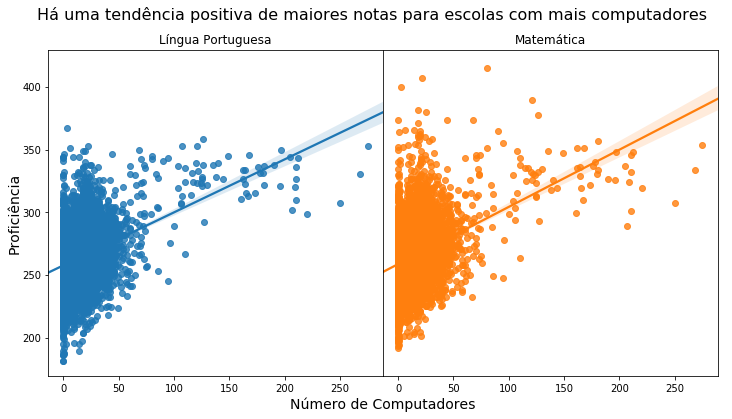

In [40]:
fig, axes = plt.subplots(figsize=(12, 6), ncols=2, sharey=True)
fig.suptitle('Há uma tendência positiva de maiores notas para escolas com mais computadores', fontsize=16)
sns.regplot(x='NU_COMP_ALUNO', y='PROFICIENCIA_LP_SAEB',data=dffinalEM_PorEscola, ax=axes[0])
sns.regplot(x='NU_COMP_ALUNO', y='PROFICIENCIA_MT_SAEB',data=dffinalEM_PorEscola, ax=axes[1])
axes[0].set(xlabel='', ylabel='')
axes[1].set(xlabel='', ylabel='')
axes[0].set_title('Língua Portuguesa')
axes[1].set_title('Matemática')
axes[0].tick_params(top=False, bottom=True, left=True, right=False)
plt.subplots_adjust(wspace=0)

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.ylabel("Proficiência" , fontsize=14)
plt.xlabel("Número de Computadores" , fontsize=14)
plt.show()

Agora vamos ver se a presença de laboratórios de ciência, de informática ou bibliotecas influenciam nas notas dos alunos. Iniciando com português depois matemática. Vamos olhar os violin plots e ver quais notas estão mais altas.

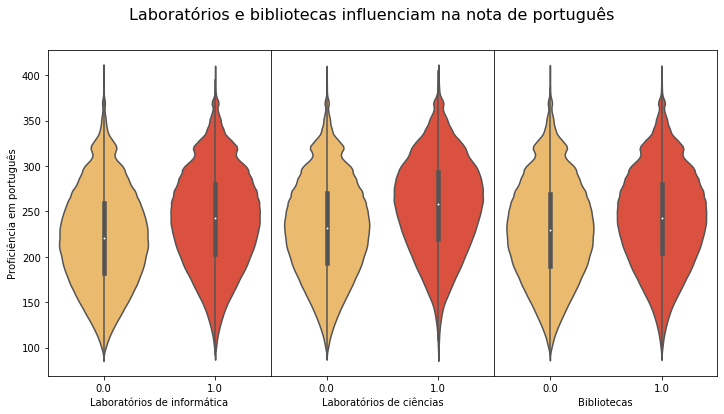

In [41]:
fig, axes = plt.subplots(figsize=(12, 6), ncols=3, sharey=True)
fig.suptitle('Laboratórios e bibliotecas influenciam na nota de português', fontsize=16)
sns.violinplot(x='IN_LABORATORIO_INFORMATICA',y='PROFICIENCIA_LP_SAEB',data=dffinal,palette='YlOrRd', ax=axes[0])
sns.violinplot(x='IN_LABORATORIO_CIENCIAS',y='PROFICIENCIA_LP_SAEB',data=dffinal,palette='YlOrRd', ax=axes[1])
sns.violinplot(x='IN_BIBLIOTECA',y='PROFICIENCIA_LP_SAEB',data=dffinal,palette='YlOrRd', ax=axes[2])
axes[0].set(xlabel='Laboratórios de informática', ylabel='Proficiência em português')
axes[1].set(xlabel='Laboratórios de ciências', ylabel='')
axes[2].set(xlabel='Bibliotecas', ylabel='')
axes[0].tick_params(top=False, bottom=True, left=True, right=False)
plt.subplots_adjust(wspace=0)
plt.show()

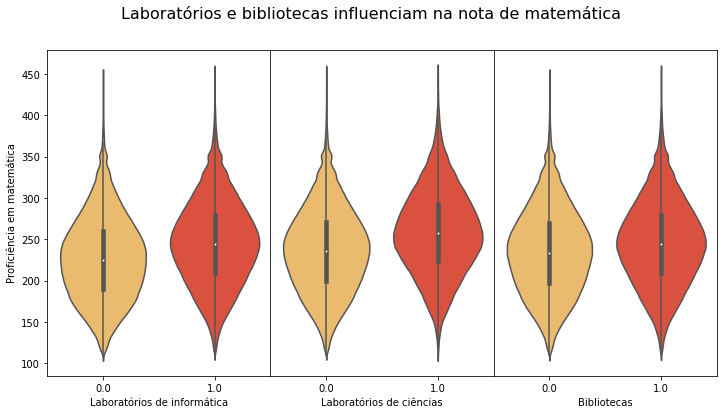

In [42]:
fig, axes = plt.subplots(figsize=(12, 6), ncols=3, sharey=True)
fig.suptitle('Laboratórios e bibliotecas influenciam na nota de matemática', fontsize=16)
sns.violinplot(x='IN_LABORATORIO_INFORMATICA',y='PROFICIENCIA_MT_SAEB',data=dffinal,palette='YlOrRd', ax=axes[0])
sns.violinplot(x='IN_LABORATORIO_CIENCIAS',y='PROFICIENCIA_MT_SAEB',data=dffinal,palette='YlOrRd', ax=axes[1])
sns.violinplot(x='IN_BIBLIOTECA',y='PROFICIENCIA_MT_SAEB',data=dffinal,palette='YlOrRd', ax=axes[2])
axes[0].set(xlabel='Laboratórios de informática', ylabel='Proficiência em matemática')
axes[1].set(xlabel='Laboratórios de ciências', ylabel='')
axes[2].set(xlabel='Bibliotecas', ylabel='')
axes[0].tick_params(top=False, bottom=True, left=True, right=False)
plt.subplots_adjust(wspace=0)
plt.show()

Observando os violin plots, percebemos que as escolas que tem estes recursos realmente tem notas mais altas em portugês e matemática. Porém isso não significa que ter estes recursos causem as notas mais altas. A causa das notas mais altas pode ser devido a outros fatores que as escolas que tem estes recursos também tem. É necessária uma maior investigação sobre isso no futuro.

# GeoAnáslise

Para fazer esta análise, eu utilizei os metadados geográficos do IBGE. Que fornecem os contornos de Municípios, Estados e do Pais. Junto com os dados já tratados nesse notebook, consigo distribuir as notas dos alunos pelos mapas que são gerados pelo GeoPandas. 

In [43]:
dffinal.head()

,ID_UF,ID_SERIE,ID_ALUNO,ID_ESCOLA,ID_TURMA,PROFICIENCIA_LP_SAEB,PROFICIENCIA_MT_SAEB,SEXO,DEPENDENCIA_ADM,CO_MUNICIPIO,CO_MICRORREGIAO,CO_UF,IN_LABORATORIO_INFORMATICA,NU_COMP_ALUNO,IN_LABORATORIO_CIENCIAS,IN_BIBLIOTECA
0,11,5,21524786,11024666,757200,231.260023,263.311860,Feminino,Municipal,1100015.0,11006.0,11.0,0.0,0.0,0.0,0.0
1,11,5,21524787,11024666,757200,142.906301,252.234895,Feminino,Municipal,1100015.0,11006.0,11.0,0.0,0.0,0.0,0.0
2,11,5,21524789,11024666,757200,145.897485,152.702955,Masculino,Municipal,1100015.0,11006.0,11.0,0.0,0.0,0.0,0.0
3,11,5,21524790,11024666,757200,238.151321,262.808438,Feminino,Municipal,1100015.0,11006.0,11.0,0.0,0.0,0.0,0.0
4,11,5,21524792,11024666,757200,235.423869,269.327887,Feminino,Municipal,1100015.0,11006.0,11.0,0.0,0.0,0.0,0.0


In [44]:
media_geral = dffinal[['PROFICIENCIA_MT_SAEB','PROFICIENCIA_LP_SAEB','IN_LABORATORIO_INFORMATICA','IN_LABORATORIO_CIENCIAS','IN_BIBLIOTECA','NU_COMP_ALUNO']].mean()
media_geral

PROFICIENCIA_MT_SAEB          243.377322
PROFICIENCIA_LP_SAEB          239.987978
IN_LABORATORIO_INFORMATICA      0.767447
IN_LABORATORIO_CIENCIAS         0.212023
IN_BIBLIOTECA                   0.582248
NU_COMP_ALUNO                  12.976924
dtype: float64

A média de notas de matemática no Brasil é 243 e de português é 239. Aproximadamente 4 entre 5 escolas tem laboratório de informática. Aproximadamente 1 entre 5 escolas tem laboratório de ciências e Aproximadamente 3 entre 5 escolas tem biblioteca. A média de computadores nas escolas disponíveis para os alunos no Brasil é de 13 computadores.

In [45]:
brmapmi = gpd.read_file('geodados/BR/BRMIE250GC_SIR.shp')
brmapuf = gpd.read_file('geodados/BR/BRUFE250GC_SIR.shp')
brmapmu = gpd.read_file('geodados/BR/BRMUE250GC_SIR.shp')

Vou focar nesta fase na educação mais fundamental da qual temos os dados, que é o 5° ano. Eu agrupo os dados dos alunos do 5° ano por microrregião, tiro a média das notas e depois mudo o nome da coluna para ficar igual ao nome do dataframe com o mapa.

In [46]:
dfmicro = dffinal[dffinal.ID_SERIE == 5].groupby('CO_MICRORREGIAO').mean()
dfmicro = dfmicro.reset_index()
dfmicro['CD_GEOCMI'] = dfmicro['CO_MICRORREGIAO']
dfmicro = dfmicro.drop(labels='CO_MICRORREGIAO', axis=1)

Adiciono os dados do mapa ao dataframe com os dados dos alunos.

In [47]:
brmapmi.CD_GEOCMI = brmapmi.CD_GEOCMI.astype(float)
dfmeanmicro = pd.merge(dfmicro, brmapmi, how='outer', on= 'CD_GEOCMI')

Então crio o plot com a média de notas por microrregião.

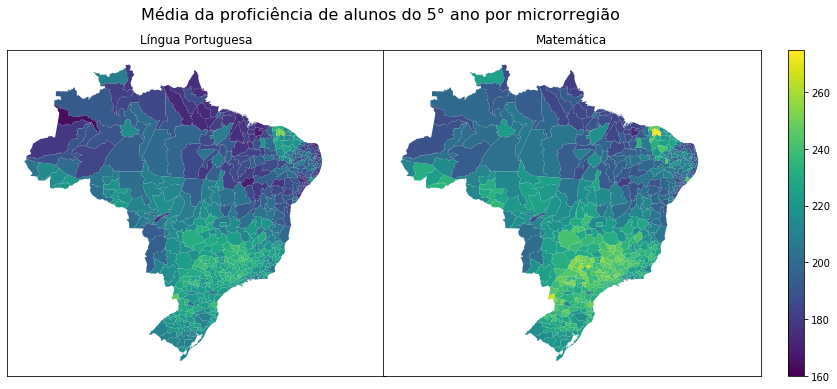

In [48]:
fig, axes = plt.subplots(figsize=(17, 6), ncols=2, sharey=True, sharex=True)
fig.suptitle('Média da proficiência de alunos do 5° ano por microrregião', fontsize=16)

gpd.GeoDataFrame(dfmeanmicro, geometry=dfmeanmicro.geometry).dropna().plot(vmin = 160,vmax = 275,column='PROFICIENCIA_LP_SAEB',legend=False, ax=axes[0])
gpd.GeoDataFrame(dfmeanmicro, geometry=dfmeanmicro.geometry).dropna().plot(vmin = 160,vmax = 275,column='PROFICIENCIA_MT_SAEB',legend=True, ax=axes[1])
axes[0].set_title('Língua Portuguesa')
axes[1].set_title('Matemática')

plt.subplots_adjust(wspace=-0.27)
axes[0].tick_params(top=False, bottom=False, left=False, right=False)
axes[1].tick_params(top=False, bottom=False, left=False, right=False)
axes[0].set_yticklabels([])
axes[1].set_xticklabels([])
axes[1].set_xticklabels([])
plt.show()

Olhando o mapa percebe-se que as notas de português são no geral mais baixas que as notas de matemática. As microrregiões do norte e do nordeste tem menores notas, ficando em destaque positivo o estado do Ceará com notas maiores do que as das regiões próximas, inclusive com uma microrregião com grande destaque positivo. Vamos investigar essa região.

In [49]:
print ('Microrregião com maior média de notas em Português do Brasil :', dfmeanmicro[dfmeanmicro.PROFICIENCIA_LP_SAEB == dfmeanmicro.PROFICIENCIA_LP_SAEB.max()].NM_MICRO[104])
print ('Microrregião com maior média de notas em Matemática do Brasil :', dfmeanmicro[dfmeanmicro.PROFICIENCIA_MT_SAEB == dfmeanmicro.PROFICIENCIA_MT_SAEB.max()].NM_MICRO[104])

Microrregião com maior média de notas em Português do Brasil : SOBRAL
Microrregião com maior média de notas em Matemática do Brasil : SOBRAL


O município de Sobral parece se destacar positivamente no ensino fundamental no Brasil.

In [50]:
print('Número de escolas avaliadas em Sobral:', dffinal[dffinal.CO_MUNICIPIO == 2312908].ID_ESCOLA.nunique())

Número de escolas avaliadas em Sobral: 56


Há um número considerável de escolas avaliadas em Sobral. Para comparar Sobral com os outros municípios, criei um DataFrame com as informações médias somente de Sobral e juntei com o DataFrame com as informações médias do Brasil inteiro.

In [51]:
SOBRAL = dfmeanmicro[dfmeanmicro.NM_MICRO == 'SOBRAL'][['PROFICIENCIA_MT_SAEB','PROFICIENCIA_LP_SAEB','IN_LABORATORIO_INFORMATICA','IN_LABORATORIO_CIENCIAS','IN_BIBLIOTECA','NU_COMP_ALUNO']]
S_BR_mean = pd.DataFrame([pd.Series(SOBRAL.transpose()[104]), media_geral], index = ['Sobral','Brasil'])
S_BR_mean

,PROFICIENCIA_MT_SAEB,PROFICIENCIA_LP_SAEB,IN_LABORATORIO_INFORMATICA,IN_LABORATORIO_CIENCIAS,IN_BIBLIOTECA,NU_COMP_ALUNO
Sobral,274.484714,253.061362,0.617570,0.000000,0.623615,9.993351
Brasil,243.377322,239.987978,0.767447,0.212023,0.582248,12.976924


Criei então um plot para comparar visualmente as notas de Sobral com o Brasil.

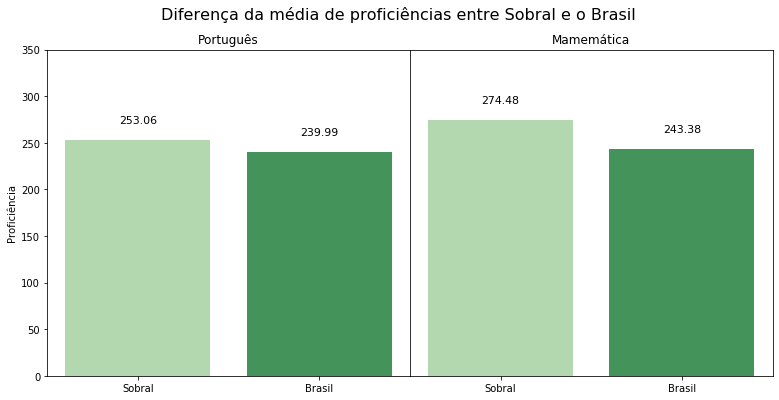

In [52]:
fig, axes = plt.subplots(figsize=(13, 6), ncols=2, sharey=True, sharex=True)
fig.suptitle('Diferença da média de proficiências entre Sobral e o Brasil', fontsize=16)

sns.barplot(y = S_BR_mean.PROFICIENCIA_LP_SAEB.values, x = S_BR_mean.PROFICIENCIA_LP_SAEB.index, palette='Greens', ax=axes[0])
axes[0].set(title='Português',ylabel='Proficiência', xlabel='')

sns.barplot(y = S_BR_mean.PROFICIENCIA_MT_SAEB.values, x = S_BR_mean.PROFICIENCIA_MT_SAEB.index, palette='Greens', ax=axes[1])
axes[1].set(title='Mamemática',ylabel='', xlabel='')

plt.ylim(0,350)
axes[0].tick_params(top=False, bottom=True, left=True, right=False)
axes[1].tick_params(top=False, bottom=True, left=False, right=False)
plt.subplots_adjust(wspace=0)

for i in range(2):
    for p in axes[i].patches:
            axes[i].annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=11, color='black', xytext=(0, 20),
                textcoords='offset points')

plt.show()

Olhando visualmente a diferença de notas não é tão evidente para português, mas para matemática a diferença já se torna mais expressiva.

Também crio um plot para comparar visualmente a média da quantidade de Laboratórios e bibliotecas de Sobral com o Brasil.

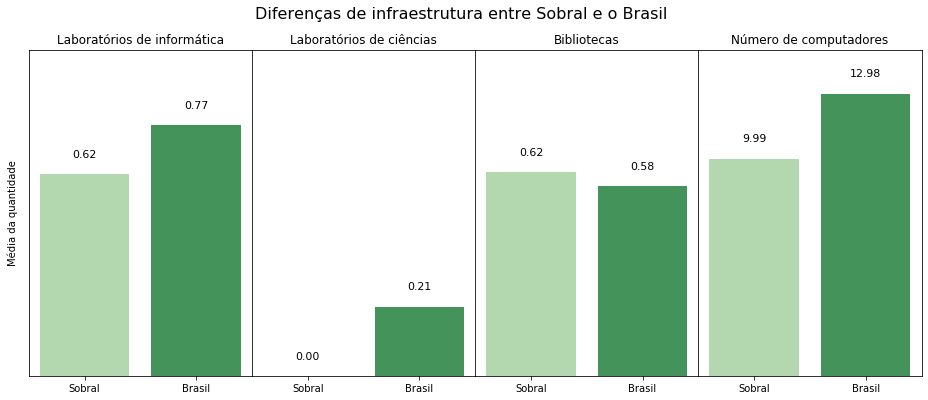

In [53]:
fig, axes = plt.subplots(figsize=(16, 6), ncols=4, sharey=False, sharex=True)
fig.suptitle('Diferenças de infraestrutura entre Sobral e o Brasil', fontsize=16)

sns.barplot(y=S_BR_mean.IN_LABORATORIO_INFORMATICA.values, x=S_BR_mean.IN_LABORATORIO_INFORMATICA.index, palette='Greens', ax=axes[0])
axes[0].set(title='Laboratórios de informática',ylabel='Média da quantidade', xlabel='')
axes[0].set_ylim(0,1)

sns.barplot(y=S_BR_mean.IN_LABORATORIO_CIENCIAS.values, x=S_BR_mean.IN_LABORATORIO_CIENCIAS.index, palette='Greens', ax=axes[1])
axes[1].set(title='Laboratórios de ciências',ylabel='', xlabel='')
axes[1].set_ylim(0,1)

sns.barplot(y=S_BR_mean.IN_BIBLIOTECA.values, x=S_BR_mean.IN_BIBLIOTECA.index, palette='Greens', ax=axes[2])
axes[2].set(title='Bibliotecas',ylabel='', xlabel='')
axes[2].set_ylim(0,1)

sns.barplot(y=S_BR_mean.NU_COMP_ALUNO.values, x=S_BR_mean.NU_COMP_ALUNO.index, palette='Greens', ax=axes[3])
axes[3].set(title='Número de computadores',ylabel='', xlabel='')
axes[3].set_ylim(0,15)

plt.subplots_adjust(wspace=0)

for i in range(4):
    axes[i].tick_params(top=False, bottom=True, left=False, right=False)
    axes[i].set_yticklabels([])
    for p in axes[i].patches:
            axes[i].annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=11, color='black', xytext=(0, 20),
                textcoords='offset points')
            
plt.show()

Sobral tem menos laboratórios de informática que o resto do Brasil, o número de laboratórios de ciências em Sobral é 0, isso pode ser alguma falta de coleta nos dados ou pode estar correto e representar a realidade, necessita de investigação posterior. Também parecem existir menos computadores disponíveis para os alunos nas escolas de Sobral. A média da quantidade de bibliotecas nas escolas de Sobral é maior que a média do resto do Brasil, seria esse o segredo de Sobral?

Vamos investigar agora por estado, como se distribuem as notas. Para criar um mapa com as notas por estado, eu agrupo o dataframe por Id da UF.

In [54]:
dfuf = dffinal[dffinal.ID_SERIE == 5].groupby('CO_UF').mean()
dfuf = dfuf.reset_index()
dfuf['CD_GEOCUF'] = dfuf['CO_UF']
dfuf = dfuf.drop(labels='CO_UF', axis=1)

In [55]:
brmapuf.CD_GEOCUF = brmapuf.CD_GEOCUF.astype(float)
dfmeanuf = pd.merge(dfuf, brmapuf, how='outer', on= 'CD_GEOCUF')

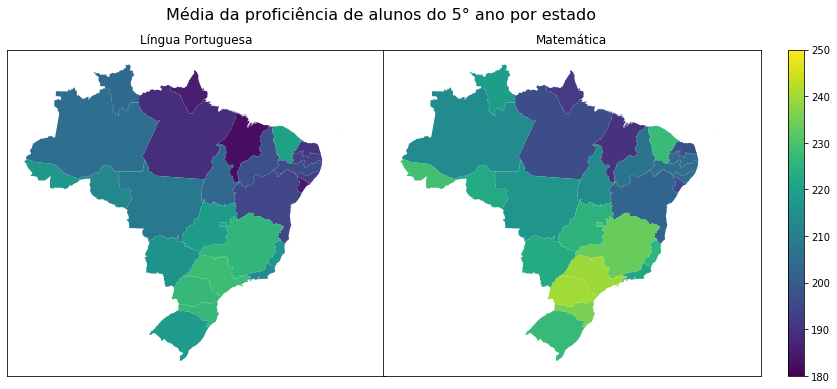

In [56]:
fig, axes = plt.subplots(figsize=(17, 6), ncols=2, sharey=True, sharex=True)
fig.suptitle('Média da proficiência de alunos do 5° ano por estado', fontsize=16)

gpd.GeoDataFrame(dfmeanuf, geometry=dfmeanuf.geometry).dropna().plot(vmin = 180,vmax = 250,column='PROFICIENCIA_LP_SAEB',legend=False, ax=axes[0])
gpd.GeoDataFrame(dfmeanuf, geometry=dfmeanuf.geometry).dropna().plot(vmin = 180,vmax = 250,column='PROFICIENCIA_MT_SAEB',legend=True, ax=axes[1])
axes[0].set_title('Língua Portuguesa')
axes[1].set_title('Matemática')

plt.subplots_adjust(wspace=-0.27)
axes[0].tick_params(top=False, bottom=False, left=False, right=False)
axes[1].tick_params(top=False, bottom=False, left=False, right=False)
axes[0].set_yticklabels([])
axes[1].set_xticklabels([])
axes[1].set_xticklabels([])
plt.show()

Olhando as notas por estado é possível perceber que há notas baixas de português no norte e nordeste, seriam possíveis locais para o governo tomar ações para melhorar o ensino de português, o estado do ceará dentre essa região é um destaque positivo, devido principalmente ao que descobrimos anteriormente que a região de Sobral tem notas muito boas. Em matemática os estados de São Paulo e do Paraná ganham destaque e tem as maiores médias de notas do país.

Vamos olhar melhor as notas de matemática no estado de São Paulo. Para criar um mapa com as notas por município do estado de São Paulo, eu agrupo o dataframe por Id do município, e depois seleciono somente os do estado de São Paulo.

In [57]:
dfmu = dffinal[dffinal.ID_SERIE == 5].groupby('CO_MUNICIPIO').mean()
dfmu = dfmu[dfmu.CO_UF == 35]
dfmu = dfmu.reset_index()
dfmu['CD_GEOCMU'] = dfmu['CO_MUNICIPIO']
dfmu = dfmu.drop(labels='CO_MUNICIPIO', axis=1)

In [58]:
brmapmu.CD_GEOCMU = brmapmu.CD_GEOCMU.astype(float)
dfmeanmu = pd.merge(dfmu, brmapmu, how='outer', on= 'CD_GEOCMU')

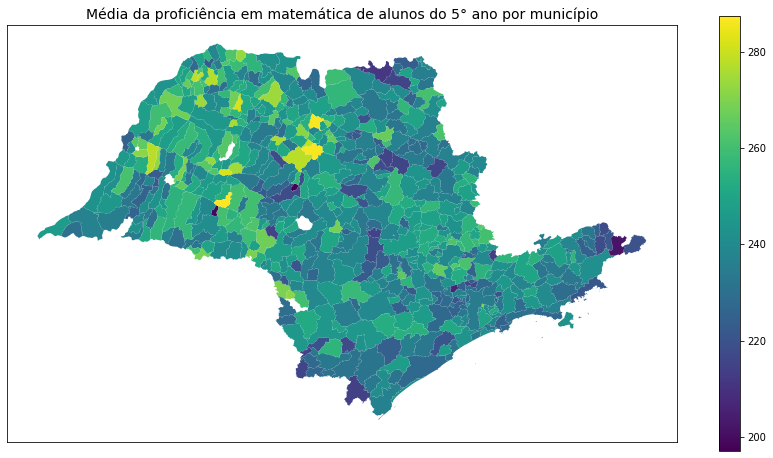

In [59]:
g = gpd.GeoDataFrame(dfmeanmu, geometry=dfmeanmu.geometry).dropna().plot(column='PROFICIENCIA_MT_SAEB',figsize=(15,8),legend=True)
plt.title('Média da proficiência em matemática de alunos do 5° ano por município', fontsize=14)

plt.tick_params(top=False, bottom=False, left=False, right=False)
g.set_yticklabels([])
g.set_xticklabels([])

plt.show()

Algumas cidades ficaram em branco pois não tiveram a nota atribuída. Muitas cidades do interior tem uma nota alta em matemática comparadas com a capital paulista.

In [60]:
print('Município com maior nota no estado:', dfmeanmu.sort_values(by='PROFICIENCIA_MT_SAEB', ascending=False )[['NM_MUNICIP','PROFICIENCIA_MT_SAEB']].head(1).values[0][0],
      ', Nota:', dfmeanmu.sort_values(by='PROFICIENCIA_MT_SAEB', ascending=False )[['NM_MUNICIP','PROFICIENCIA_MT_SAEB']].head(1).values[0][1])
print('Nota no Município de São Paulo:', dfmeanmu[dfmeanmu.CD_GEOCMU == 3550308]['PROFICIENCIA_MT_SAEB'].values[0])

Município com maior nota no estado: QUINTANA , Nota: 287.3897504615385
Nota no Município de São Paulo: 234.31482511592037


Com a análise podemos concluir que muito pode ser feito pela educação no Brasil, e que a disparidade entre os alunos com menores notas e os com maiores notas é grande, assim como também entre as escolas estaduais, municipais e privadas. Investimentos em infraestrutura como adicionar laboratórios de ciências, de informática, bibliotecas e até aumentar o número de computadores disponíveis para os alunos, podem melhorar a nota destes em português e matemática. O norte e o nordeste precisam de antenção no ensino de português, o Ceará tem destaque positivo em notas no nordeste. Os estados com melhores notas do Brasil são São Paulo e o Paraná.